<a href="https://colab.research.google.com/github/ganesh2512/finalProjectML/blob/main/Final_Project_DSBA6156.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goal: Predict employee attrition using predictive techniques to improve employee retention.
--- Alvis Chung, Ganesh Viswanathan, Minglan Ye, Niraj Bista

# **Import packages**

In [1]:
import numpy as np 
import pandas as pd 
import sklearn 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression

# **Read Data**

In [2]:
df = pd.read_csv('./content/DR_Demo_Employee_Attrition.csv')
df.head(2)

,EmployeeNumber,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,performance_review
0,1,Yes,42,Travel_Rarely,1147,Human Resources,10,3,Human Resources,1,...,80,1,21.0,5,3,20,7,0,9,"Teamwork Satisfactory he gives candid, con..."
1,2,No,31,Travel_Rarely,267,Research & Development,21,3,Medical,1,...,80,3,14.0,6,3,14,11,2,13,\rTeamwork Exceeds requirements\rHe gi...


# **NLP Analysis**

In [3]:
# Preparing the performance review feature to analyze the sentiment of the review
# Extracting only the rating and review sections to extract the sentiments
def build_dataset_nlp():

    features = ['PerformanceRating'
                ,'performance_review'
               ]
data = df[['PerformanceRating','performance_review']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nkbista/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nkbista/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


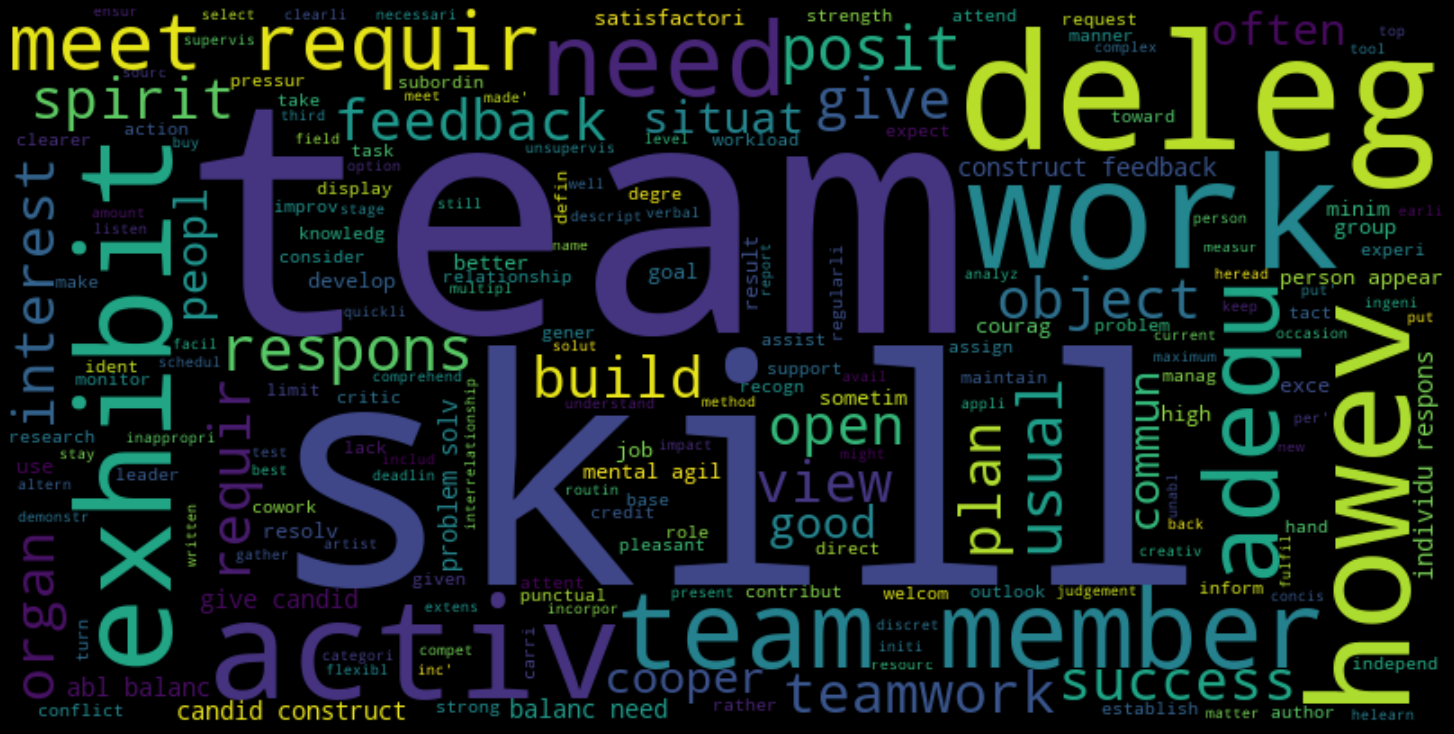

In [4]:
data_performance_review = data[['performance_review']]
data_performance_review = data_performance_review.dropna()
data_performance_review['performance_review'] = data_performance_review['performance_review'].astype(str)
data_performance_review['performance_review'] = data_performance_review['performance_review'].str.lower()
punct_to_remove = string.punctuation
punct_to_remove

#Data clean up to prepare for NLP - normalizing and standardizing the text removing puntuation, stopwords, stemming and lemetization
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('zzilzdasfasdfzcxvzxcvzxdfasdfasdf', '', punct_to_remove))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])            

# Stop words (removing who, the, that, etc...)
data_performance_review["text_wo_punct"] = data_performance_review['performance_review'].apply(lambda text: remove_punctuation(text))
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
STOPWORDS = set(stopwords.words('english'))

# Data cleaning process (removing symbols/punctuation)
data_performance_review["text_wo_stop"] = data_performance_review["text_wo_punct"].apply(lambda text: remove_stopwords(text))
data_performance_review.drop(['performance_review','text_wo_punct'], axis=1, inplace=True)

# Stemming (group all similar words into 1 (issuing, issues, issued -> issue))
stemmer = PorterStemmer()
data_performance_review["text_stemmed"] = data_performance_review["text_wo_stop"].apply(lambda text: stem_words(text))
lemmatizer = WordNetLemmatizer()

# Lemmatizing (group all similar word by reducing the end of words)
nltk.download('wordnet')
data_performance_review["text_lemmatized"] = data_performance_review["text_stemmed"].apply(lambda text: lemmatize_words(text))

# Creating a word cloud to get all the words and their frequencies depicted - EDA of the text feature
text = data_performance_review['text_lemmatized'].values 
wordcloud = WordCloud(width=800, height=400, max_words=200).generate(str(text))

# Ploting word cloud
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Updating the performance_review collumn with the cleaned up text from EDA and processing as above
data.drop('performance_review', inplace=True, axis=1)
data['performance_review'] = data_performance_review['text_lemmatized']

In [5]:
# Based on EDA we have performance rating to be bad when its 3 and good when its 4. We are using this to apply bag the words later on
data_nlp_analysis = data[['PerformanceRating', 'performance_review']]
data_nlp_analysis.PerformanceRating.replace((3, 4), (-1, 1), inplace=True)
data_nlp_analysis.rename(columns = {'PerformanceRating':'sentiment'}, inplace = True)

In [6]:
# Setting -1 to 3 and 1 to 4 in performancing rating column

Good Review


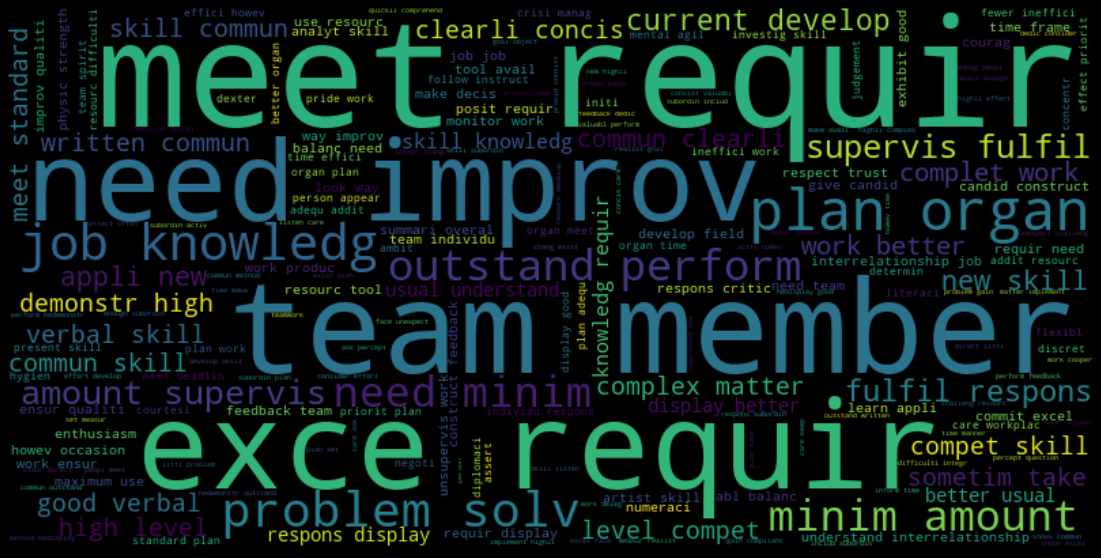

<Figure size 1440x720 with 0 Axes>

Bad Review


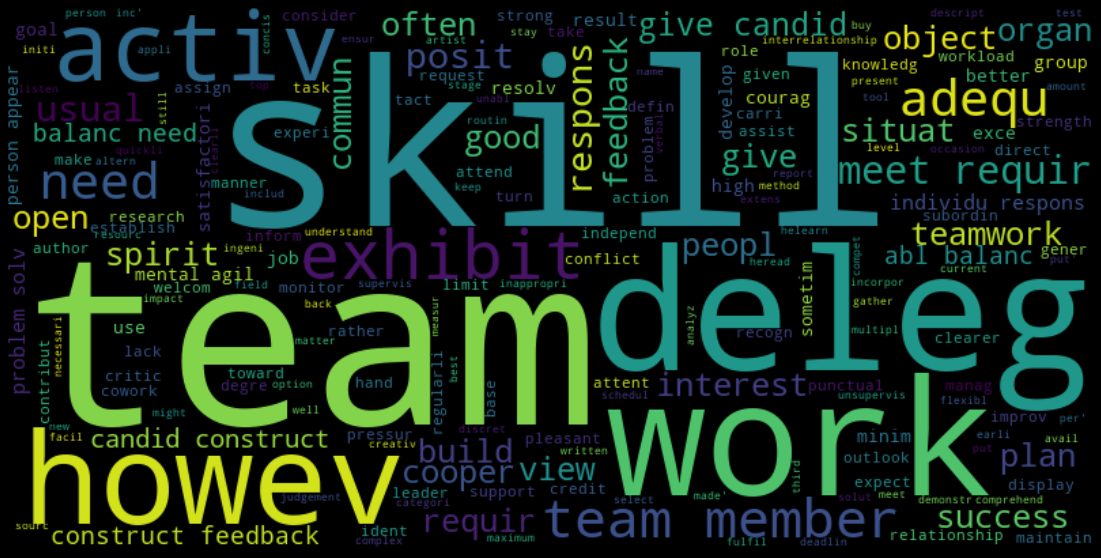

<Figure size 1440x720 with 0 Axes>

-1    4859
 1     881
Name: sentiment, dtype: int64


In [7]:
# Bag of words approach. The bags of words are based on performance rating and depicted as word cloud
# Sentiment is basically the performance rating feature

# Printing word cloud in good review
print("Good Review")
text = data_nlp_analysis.loc[data_nlp_analysis['sentiment'] == 1]['performance_review'].values 
wordcloud = WordCloud(width=800, height=400, max_words=200).generate(str(text))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure( figsize=(20,10), facecolor='k')
plt.show()

# Printing word cloud in bad review
print("Bad Review")
text = data_nlp_analysis.loc[data_nlp_analysis['sentiment'] == -1]['performance_review'].values  
wordcloud = WordCloud(width=800, height=400, max_words=200).generate(str(text))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure( figsize=(20,10), facecolor='k')
plt.show()

print(data_nlp_analysis.sentiment.value_counts())


In [8]:
# Random split train and test data - This is done to model the data to convert the text into sentiments which can be used in overall model later on
index = data_nlp_analysis.index
data_nlp_analysis['random_number'] = np.random.randn(len(index))
data_nlp_analysis.head(5)
train = data_nlp_analysis[data_nlp_analysis['random_number'] <= 0.8]
test = data_nlp_analysis[data_nlp_analysis['random_number'] > 0.8]

print(train.sentiment.value_counts())
print(test.sentiment.value_counts())

-1    3786
 1     685
Name: sentiment, dtype: int64
-1    1073
 1     196
Name: sentiment, dtype: int64


In [9]:
# TFIDF vectorizer is used to convert the words into frequencies normalized by the occurance. We do this to ensure that common words do not bias the output
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'), ngram_range = (2,4))

train_matrix = vectorizer.fit_transform(train['performance_review']).toarray()
features = (vectorizer.get_feature_names()) 
test_matrix = vectorizer.transform(test['performance_review']).toarray()

# Logistic regression is being applied to prepare the NLP data and convert it onto sentiments
lr = LogisticRegression(class_weight = 'balanced',C=0.001, penalty='l2')


X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']


lr.fit(X_train,y_train)

# Predictions on sentiments based on text
predictions = lr.predict(X_test)
print(predictions)

unique_elements, counts_elements = np.unique(predictions, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

# Overall Datasets modified with the newly calculated sentiments
data_WithAnalysis = df
data_WithAnalysis['sentiment_Score'] = lr.predict(vectorizer.fit_transform(data['performance_review']).toarray())
data_WithAnalysis.head(5)

[-1 -1  1 ...  1 -1  1]
Frequency of unique values of the said array:
[[ -1   1]
 [666 603]]


,EmployeeNumber,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,performance_review,sentiment_Score
0,1,Yes,42,Travel_Rarely,1147,Human Resources,10,3,Human Resources,1,...,1,21.0,5,3,20,7,0,9,"Teamwork Satisfactory he gives candid, con...",1
1,2,No,31,Travel_Rarely,267,Research & Development,21,3,Medical,1,...,3,14.0,6,3,14,11,2,13,\rTeamwork Exceeds requirements\rHe gi...,-1
2,3,No,36,Travel_Frequently,1394,Research & Development,8,3,Medical,1,...,1,22.0,3,3,20,11,0,7,Cooperation Meets requirements\rS...,1
3,4,No,32,Travel_Rarely,678,Research & Development,19,3,Life Sciences,1,...,0,11.0,3,3,10,9,8,7,Problem Solving Satisfactory\rhe rout...,1
4,5,No,19,Travel_Rarely,1181,Research & Development,3,1,Medical,1,...,0,1.1,3,3,1,0,0,0,Goals: Goal: Incorporate Team Members Category...,1


# **Data Visualization**

**Target feature Attrition distribution**

No     4642
Yes    1098
Name: Attrition, dtype: int64
No     0.808711
Yes    0.191289
Name: Attrition, dtype: float64


<AxesSubplot:>

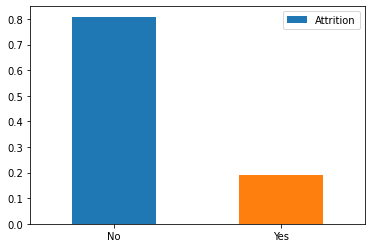

In [10]:
# Target variable
print(df['Attrition'].value_counts())
print(df['Attrition'].value_counts(normalize=True))
df['Attrition'].value_counts(normalize=True).plot(kind='bar', rot=0, color=('C0','C1'), legend='Attrition')

**Continuous features distribution**

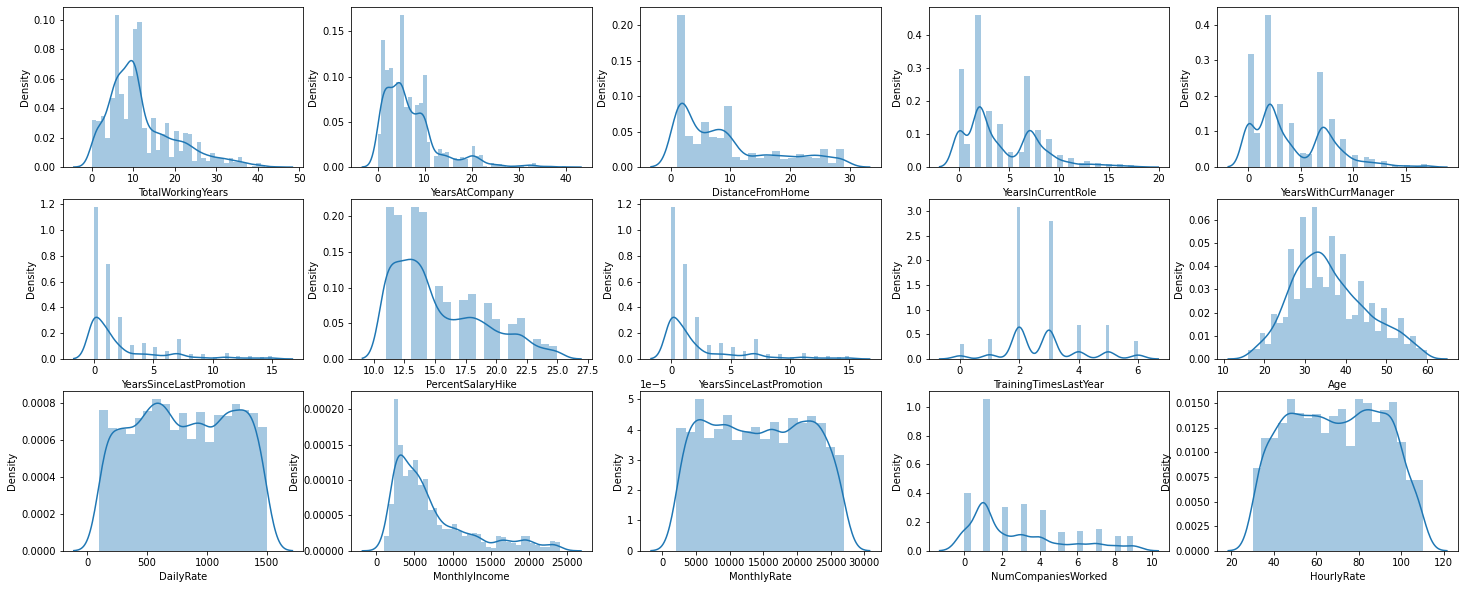

In [11]:
fig,ax = plt.subplots(3,5, figsize=(25,10))      
sns.distplot(df['TotalWorkingYears'], ax = ax[0,0]) 
sns.distplot(df['YearsAtCompany'], ax = ax[0,1]) 
sns.distplot(df['DistanceFromHome'], ax = ax[0,2]) 
sns.distplot(df['YearsInCurrentRole'], ax = ax[0,3]) 
sns.distplot(df['YearsWithCurrManager'], ax = ax[0,4]) 
sns.distplot(df['YearsSinceLastPromotion'], ax = ax[1,0]) 
sns.distplot(df['PercentSalaryHike'], ax = ax[1,1]) 
sns.distplot(df['YearsSinceLastPromotion'], ax = ax[1,2]) 
sns.distplot(df['TrainingTimesLastYear'], ax = ax[1,3]) 
sns.distplot(df['Age'], ax = ax[1,4]) 
sns.distplot(df['DailyRate'], ax = ax[2,0]) 
sns.distplot(df['MonthlyIncome'], ax = ax[2,1])
sns.distplot(df['MonthlyRate'], ax = ax[2,2])
sns.distplot(df['NumCompaniesWorked'], ax = ax[2,3])
sns.distplot(df['HourlyRate'], ax = ax[2,4])
plt.show()

**Categorical features distribution**

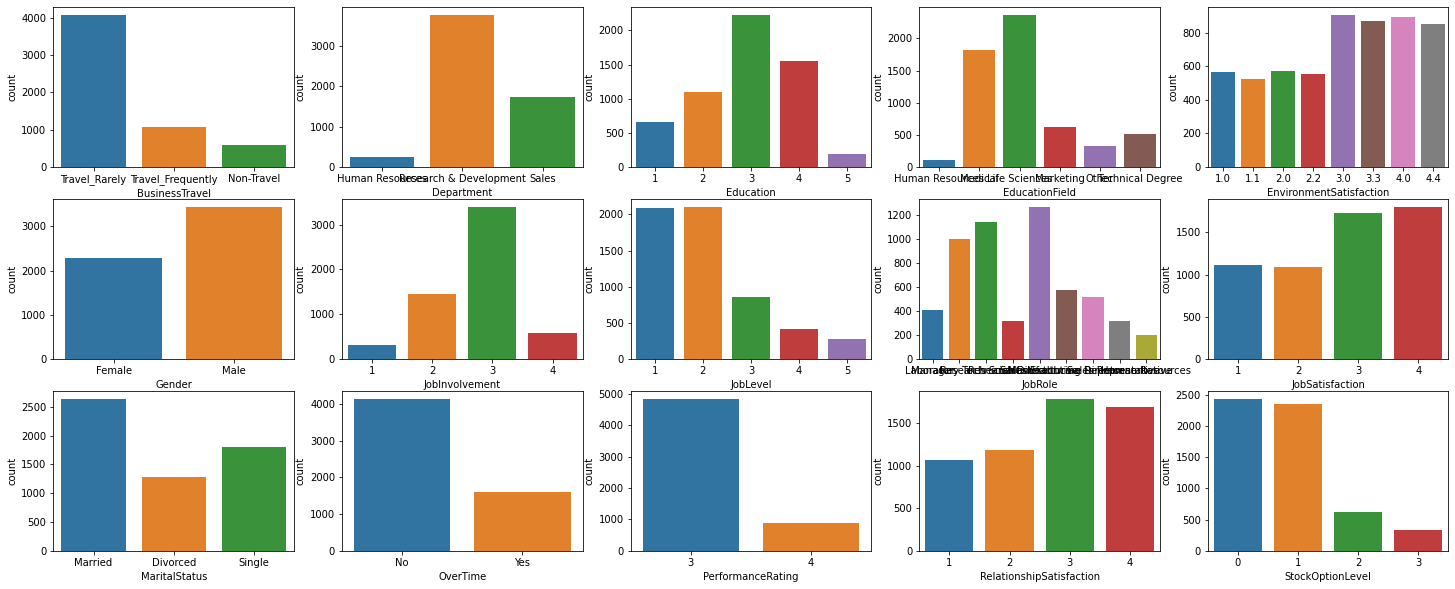

In [12]:
fig,ax = plt.subplots(3,5, figsize=(25,10))      
sns.countplot(df['BusinessTravel'], ax = ax[0,0]) 
sns.countplot(df['Department'], ax = ax[0,1]) 
sns.countplot(df['Education'], ax = ax[0,2]) 
sns.countplot(df['EducationField'], ax = ax[0,3]) 
sns.countplot(df['EnvironmentSatisfaction'], ax = ax[0,4]) 
sns.countplot(df['Gender'], ax = ax[1,0]) 
sns.countplot(df['JobInvolvement'], ax = ax[1,1]) 
sns.countplot(df['JobLevel'], ax = ax[1,2]) 
sns.countplot(df['JobRole'], ax = ax[1,3]) 
sns.countplot(df['JobSatisfaction'], ax = ax[1,4]) 
sns.countplot(df['MaritalStatus'], ax = ax[2,0]) 
sns.countplot(df['OverTime'], ax = ax[2,1])
sns.countplot(df['PerformanceRating'], ax = ax[2,2])
sns.countplot(df['RelationshipSatisfaction'], ax = ax[2,3])
sns.countplot(df['StockOptionLevel'], ax = ax[2,4])
plt.show()


**Age Feature**

<AxesSubplot:xlabel='Age', ylabel='Density'>

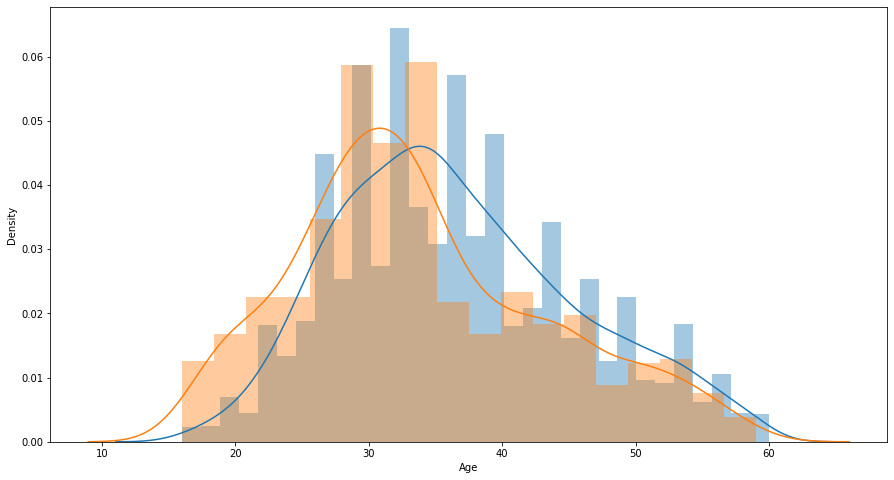

In [13]:
attrn = df[df['Attrition']=='No']['Age']
attry = df[df['Attrition']=='Yes']['Age']

plt.figure(figsize=(15,8))
sns.distplot(attrn)
sns.distplot(attry)

In [14]:
# Bar chart against target variable Attrition

def drawBarChart(x):
  print(df[x].value_counts(), end='\n\n')
  print(pd.crosstab(columns=[df['Attrition']],index=[df[x]],margins=True,normalize='index',))
  sns.catplot(x, data=df, aspect=3, kind='count', hue='Attrition', palette=['C1', 'C0']).set_ylabels('Number of Employees')


Travel_Rarely        4082
Travel_Frequently    1067
Non-Travel            591
Name: BusinessTravel, dtype: int64

Attrition                No       Yes
BusinessTravel                       
Non-Travel         0.891709  0.108291
Travel_Frequently  0.728210  0.271790
Travel_Rarely      0.817736  0.182264
All                0.808711  0.191289
Research & Development    3766
Sales                     1730
Human Resources            244
Name: Department, dtype: int64

Attrition                     No       Yes
Department                                
Human Resources         0.815574  0.184426
Research & Development  0.839352  0.160648
Sales                   0.741040  0.258960
All                     0.808711  0.191289
Life Sciences       2368
Medical             1817
Marketing            618
Technical Degree     513
Other                321
Human Resources      103
Name: EducationField, dtype: int64

Attrition               No       Yes
EducationField                      
Human Resources

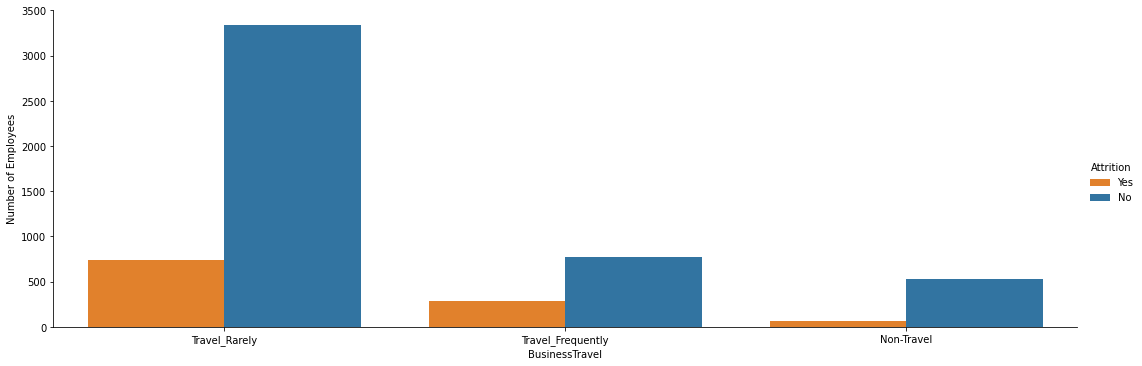

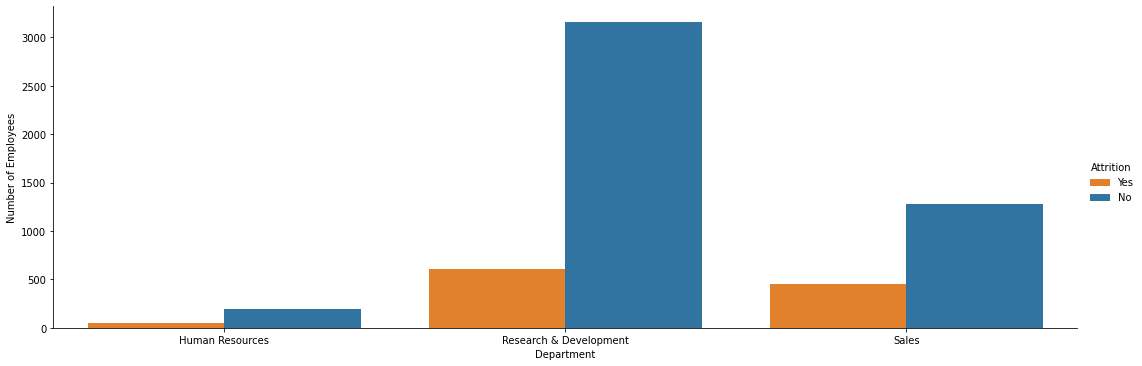

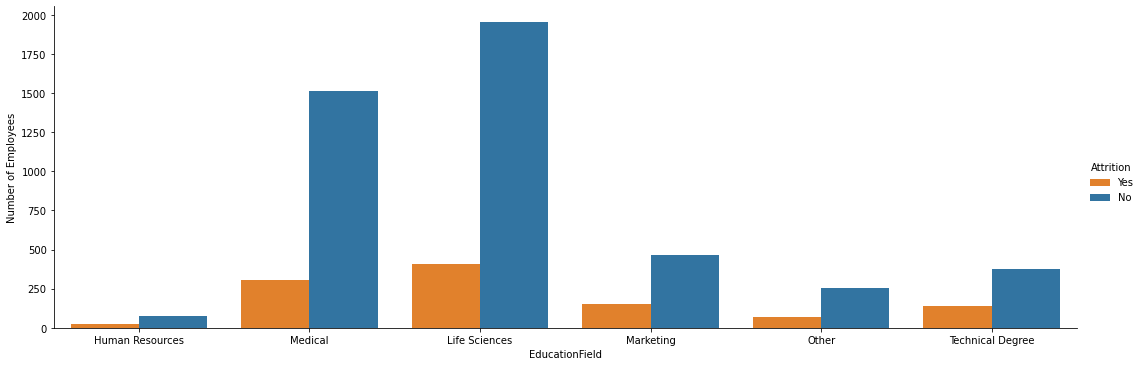

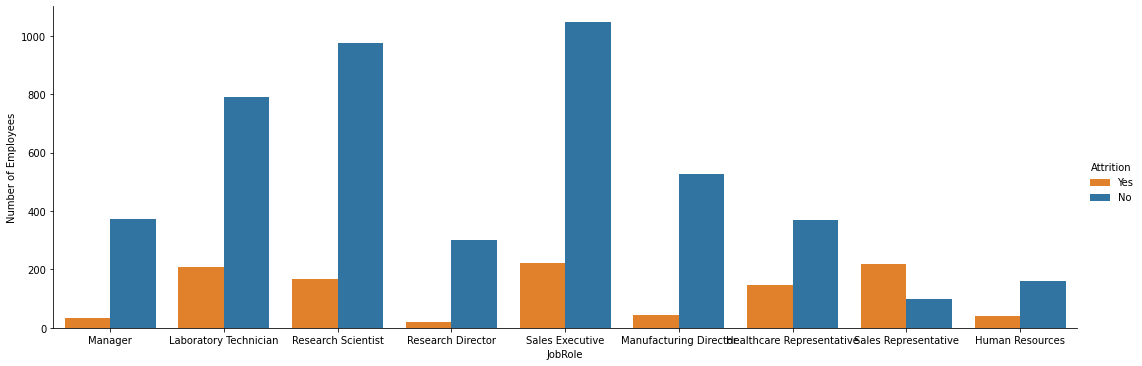

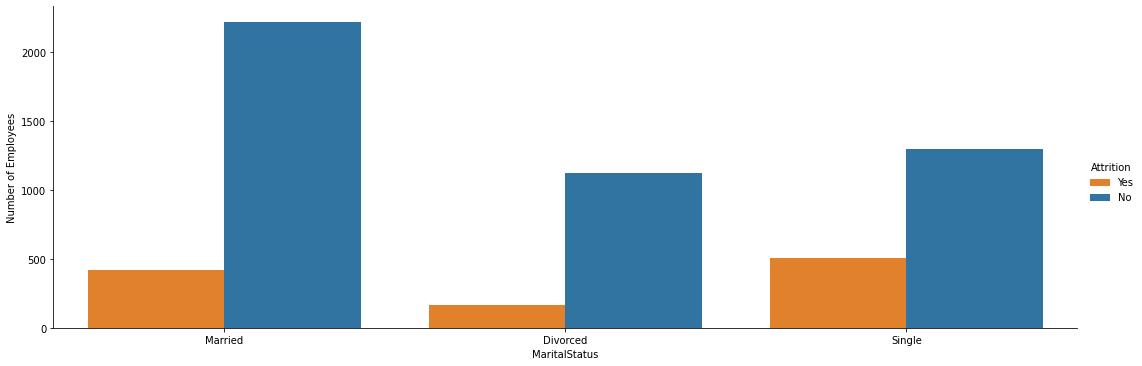

In [15]:
drawBarChart('BusinessTravel')
drawBarChart('Department')
drawBarChart('EducationField')
drawBarChart('JobRole')
drawBarChart('MaritalStatus')

**Monthly Income**

<AxesSubplot:xlabel='MonthlyIncome', ylabel='Density'>

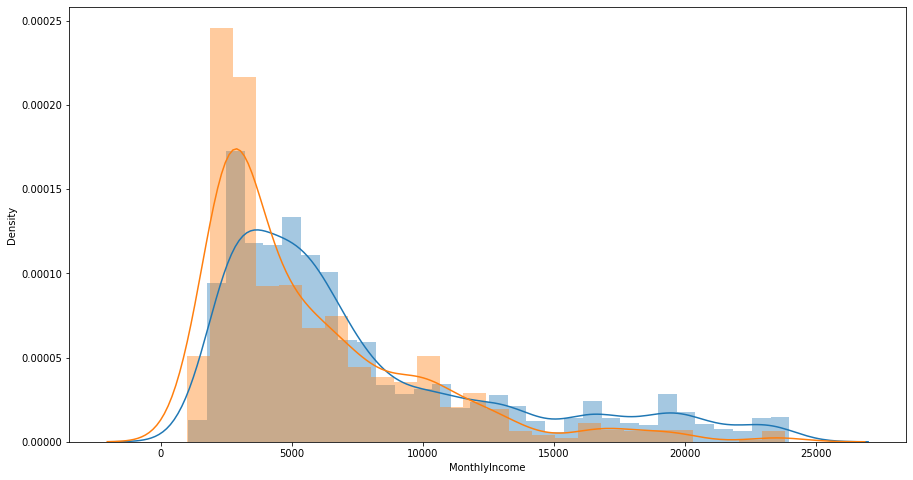

In [16]:
# Monthly Income feature
attrn = df[df['Attrition']=='No']['MonthlyIncome']
attry = df[df['Attrition']=='Yes']['MonthlyIncome']

plt.figure(figsize=(15,8))
sns.distplot(attrn)
sns.distplot(attry)

**Total Working Years**

<AxesSubplot:xlabel='TotalWorkingYears', ylabel='Density'>

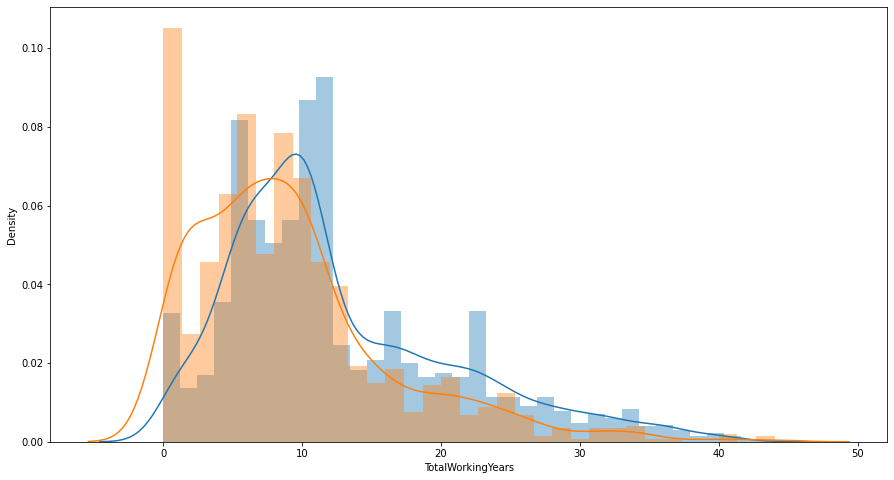

In [17]:
attrn = df[df['Attrition']=='No']['TotalWorkingYears']
attry = df[df['Attrition']=='Yes']['TotalWorkingYears']

plt.figure(figsize=(15,8))
sns.distplot(attrn)
sns.distplot(attry)


**Years At Company Feature**

<AxesSubplot:xlabel='YearsAtCompany', ylabel='Density'>

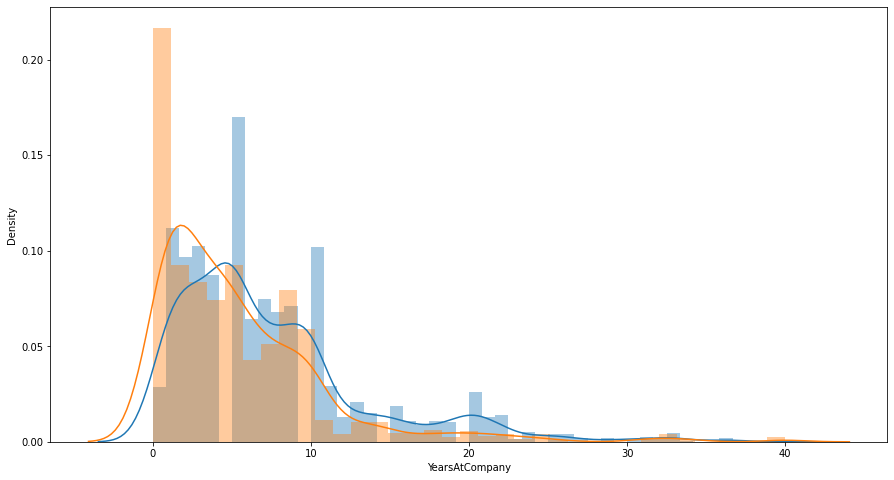

In [18]:
#YearsAtCompany
attrn = df[df['Attrition']=='No']['YearsAtCompany']
attry = df[df['Attrition']=='Yes']['YearsAtCompany']

plt.figure(figsize=(15,8))
sns.distplot(attrn)
sns.distplot(attry)

<AxesSubplot:>

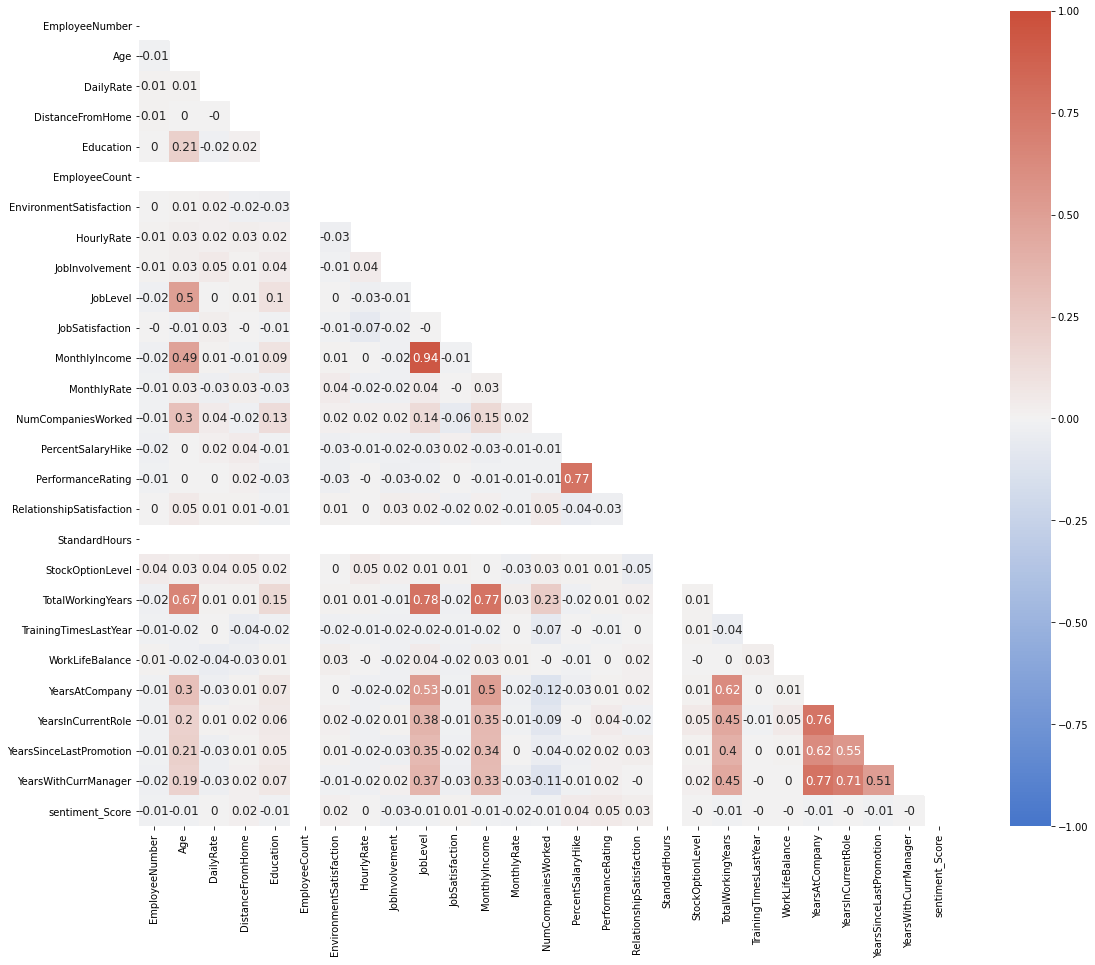

In [19]:
f, ax = plt.subplots(figsize=(20, 15))
corr = df.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            mask=mask, 
            cmap=sns.diverging_palette(255, 17, as_cmap=True),
            square=True, vmin=-1, vmax=1, annot=True, annot_kws={"size": 12}, ax=ax)


In [20]:
# Remove less significant features
df = df.drop(['EmployeeNumber', 'YearsInCurrentRole', 'PerformanceRating', 'RelationshipSatisfaction','PercentSalaryHike', 'DailyRate', 
              'DistanceFromHome', 'Gender', 'MonthlyRate', 'NumCompaniesWorked', 'TrainingTimesLastYear', 
              'WorkLifeBalance','Over18', 'performance_review'], axis=1)

# **Refined Data**

In [21]:
df_refined = df.copy()
df_refined

,Attrition,Age,BusinessTravel,Department,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,MaritalStatus,MonthlyIncome,OverTime,StandardHours,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,sentiment_Score
0,Yes,42,Travel_Rarely,Human Resources,3,Human Resources,1,3.0,31.0,3,...,Married,16799.0,No,80,1,21.0,20,0,9,1
1,No,31,Travel_Rarely,Research & Development,3,Medical,1,2.0,79.0,4,...,Married,2028.0,No,80,3,14.0,14,2,13,-1
2,No,36,Travel_Frequently,Research & Development,3,Medical,1,4.4,63.8,2,...,Divorced,2559.6,Yes,80,1,22.0,20,0,7,1
3,No,32,Travel_Rarely,Research & Development,3,Life Sciences,1,2.2,38.5,2,...,Married,3514.8,No,80,0,11.0,10,8,7,1
4,No,19,Travel_Rarely,Research & Development,1,Medical,1,2.2,86.9,3,...,Single,1779.6,No,80,0,1.1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,No,54,Travel_Rarely,Human Resources,4,Medical,1,3.0,88.0,3,...,Married,10725.0,No,80,1,16.0,9,7,1,-1
5736,No,40,Travel_Rarely,Research & Development,3,Life Sciences,1,3.0,52.0,3,...,Divorced,6513.0,No,80,1,12.0,5,0,3,-1
5737,Yes,27,Travel_Rarely,Sales,1,Life Sciences,1,4.0,45.0,2,...,Married,7336.0,No,80,1,11.0,11,3,10,-1
5738,No,35,Travel_Rarely,Research & Development,5,Life Sciences,1,2.0,48.0,4,...,Married,5208.0,No,80,0,16.0,16,1,10,-1


In [22]:
df_refined.columns

Index(['Attrition', 'Age', 'BusinessTravel', 'Department', 'Education',
       'EducationField', 'EmployeeCount', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'OverTime',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'sentiment_Score'],
      dtype='object')

## Create Transformers 

In [23]:
# Numeric transformer 
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categorical transformer 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

## Apply Transformation by using ColumnTransformer  

In [24]:
# Numeric columns 
numeric_features = df_refined.select_dtypes(include=['int64','float64']).columns

# Categorical columns 
categorical_features = df_refined.select_dtypes(include=['object']).drop(['Attrition'], axis=1).columns

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat',categorical_transformer, categorical_features)
])

In [25]:
# Split the data intro train and test set 

X = df_refined.drop(['Attrition'], axis = 1) 
y = df_refined[['Attrition']]

X_train, X_test ,y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state=42)

## Perform Random Forest Model Using Pipeline to find feature importance

In [26]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn import ensemble

rf_feature_importance = ensemble.RandomForestClassifier(n_estimators = 500
                                     , max_features = 5
                                     , random_state = 12345
                                     , max_depth = 8
                                     , min_samples_split = 500
                                     , min_samples_leaf = 5
                                     , max_leaf_nodes = 10)

pipe_feature_importance = Pipeline([('preprocessor', preprocessor),('rf', rf_feature_importance)])

In [27]:
pipe_feature_importance.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'StandardHours', 'StockOptionLevel',
       'TotalWorki...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
       

## Measure Features Importance Variables

In [28]:
# Setting features importance to best parameter random forest model
features_importance = model_feature_importance.feature_importances_
 
list = print("Feature Importances:")
data_x = []
data_y = []
for i, data_class in enumerate(X):
    data_x.append(data_class)
    data_y.append(features_importance[i])
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))

Feature Importances:
1. Age (0.03387625480008171)
2. BusinessTravel (0.0013110774226350924)
3. Department (0.0)
4. Education (0.011655413895374006)
5. EducationField (0.10612556310240207)
6. EmployeeCount (0.008293825079060263)
7. EnvironmentSatisfaction (0.048346642540476485)
8. HourlyRate (0.009555862178683814)
9. JobInvolvement (0.07831516942061645)
10. JobLevel (0.0)
11. JobRole (0.04501367503204824)
12. JobSatisfaction (0.09972802818743527)
13. MaritalStatus (0.0425776339776064)
14. MonthlyIncome (0.0032619389566094052)
15. OverTime (0.032836145491942574)
16. StandardHours (6.982835128508228e-05)
17. StockOptionLevel (0.0025339784812685173)
18. TotalWorkingYears (0.006498213153624078)
19. YearsAtCompany (0.0004894365074860101)
20. YearsSinceLastPromotion (0.00011649035060625535)
21. YearsWithCurrManager (0.021179657927156377)
22. sentiment_Score (0.037326581472542704)


In [29]:
# Ploting Feature Importance Score
import matplotlib.pyplot as plt

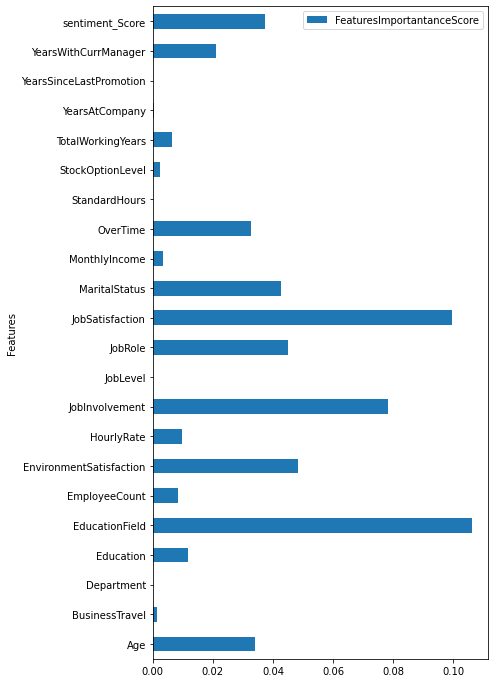

In [30]:
df1 = pd.DataFrame({'Features': data_x, 'FeaturesImportantanceScore': data_y})
ax = df1.plot.barh(x='Features', y='FeaturesImportantanceScore', figsize=(6,12))

## Fitting the Classifier 

In [31]:
# Create a pipeline which combines the preprocessor created with a classifier 

pipe = Pipeline(steps=[('preprocessor',preprocessor),
                      ('classifier',RandomForestClassifier())])

In [32]:
# Call the fit method 
pipe.fit(X_train,y_train) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'StandardHours', 'StockOptionLevel',
       'TotalWorki...
       'YearsWithCurrManager', 'sentiment_Score'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(

In [33]:
# Predict on new (test) data and accuracy score 
y_preds = pipe.predict(X_test) 
print("Accuracy score on test data: [{:.3f}]".format(accuracy_score(y_test,y_preds)))

Accuracy score on test data: [0.927]


## Model Selection 

In [34]:
# Import classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [35]:
# Call classifiers 
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

In [36]:
# Measure Accuracy Score for different models with test set
print("\n *** Accuracy score of test data using diffrent classifier: ***\n")
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    pipe.fit(X_train, y_train)

    print(
          ("Accuracy score on Test split:[{:.3f}]".format(pipe.score(X_test, y_test))),classifier
         )   


 *** Accuracy score of test data using diffrent classifier: ***

Accuracy score on Test split:[0.918] KNeighborsClassifier(n_neighbors=3)
Accuracy score on Test split:[0.813] SVC(C=0.025, probability=True)
Accuracy score on Test split:[0.908] DecisionTreeClassifier()
Accuracy score on Test split:[0.927] RandomForestClassifier()
Accuracy score on Test split:[0.835] AdaBoostClassifier()
Accuracy score on Test split:[0.866] GradientBoostingClassifier()
